In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

import scipy.optimize as optimization

In [2]:
#getting stock data
stocks = ['AAPL', 'WMT', 'TSLA', 'GE', 'AMZN', 'DB']
# stocks = ['DSKY.ME', 'NKNC.ME', 'MTSS.ME', 'IRAO.ME', 'SBER.ME', 'AFLT.ME']
start_date = '2018-01-01'
end_date = '2024-01-01'

def download_data():
  df = {}
  for stock in stocks:
    ticker = yf.Ticker(stock)
    df[stock] = ticker.history(start = start_date, end = end_date)['Close']
  return pd.DataFrame(df)


In [3]:
def show_data(data):
  data.plot(figsize = (18,5))
  plt.show()

In [4]:
def calculate_return(data):
  log_return = np.log(data / data.shift(1))
  return log_return[1:]

In [5]:
COEFF = 1

In [6]:
def show_statistics(returns):
  #annual return using mean
  print(returns.mean() * COEFF)

  #remember covariance is matrix so it will return that
  print(returns.cov() * COEFF)

In [7]:
#caculating annual portfolio return and overall volatility of portfolio
def show_mean_variance(returns, weights):
  portfolio_return = np.sum(returns.mean() * weights) * COEFF
  portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * COEFF, weights)))
  print("Expected portfolio mean(return):", portfolio_return)
  print("Expected portfolio volatility(standerd deviation):", portfolio_volatility)


In [8]:
def generate_portfolios(returns):
  portfolio_means = []
  portfolio_risks = []
  portfolio_weights = []

  for i in range(10000):
    w = np.random.random(len(stocks))
    w /= np.sum(w)
    portfolio_weights.append(w)
    # returns.mean() -  среднее по одной акции на протяжении всего времени
    portfolio_means.append(np.sum(returns.mean() * w) * COEFF)
    portfolio_risks.append(np.sqrt(np.dot(w.T, np.dot(returns.cov() * COEFF, w))))

  return np.array(portfolio_weights), np.array(portfolio_means), np.array(portfolio_risks)

In [9]:
def show_portfolios(returns,volatilities):
  plt.figure(figsize = (18,6))
  plt.scatter(volatilities, returns, c = returns / volatilities, marker='o')
  plt.grid(True)
  plt.xlabel('Expected Volatility')
  plt.ylabel('Expected Return')
  plt.colorbar(label = 'Sharp Ratio')
  plt.show()

In [10]:
def statistics(weights, returns):
  portfolio_return = np.sum(returns.mean() * weights) * COEFF
  portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * COEFF, weights)))
  return np.array([portfolio_return, portfolio_volatility, portfolio_return / portfolio_volatility])


In [11]:
#scipy find min of given function so we wil find min of -f(x) to get max of f(x)
#f(x)=0 this is the function to minimize
# минимальный риск при заданной степени дохода
def min_function_sharp(weights, returns):
  return statistics(weights, returns)[1]
# было return -statistics(weights, returns)[2]


In [12]:
DOHOD = 0.000824740721
# Пусть будет 100% в год (хотим удвоить).  
# x^365 = 2, x - доходность акций
# x = 1.00190084
# Берём логарифм. ln(x) = 0.000824740721
# Модель заменяет её сложную динамику на линейную модель. То есть берёём вместо x среднюю доходность и делаем вид, что она постоянно такая

In [13]:
def optimize_portfolio(weights, returns):
  constrains = [
    {
      'type': 'eq',
      'fun': lambda x: np.sum(x) - 1
    },
    {
      'type': 'eq',
      'fun': lambda x, returns: np.sum(returns.mean() * x) * COEFF - DOHOD, # lambda x : np.sum(x) - 1
      'args': (returns,)
    },
  ]
  #the weight can be 1 at most for single stock or weights can have value with in 0 and 1
  bounds = tuple((0, 1) for _ in range(len(stocks)))
  return optimization.minimize(
    fun = min_function_sharp,
    x0 = weights[0],
    args = returns,
    method = 'SLSQP',
    bounds = bounds,
    constraints = constrains
  )


In [14]:
def print_optimal_portfolio(optimum, returns):
  print("Optimal portfolio:", optimum['x'].round(3))
  print("Expected return, volatility and sharp ratio:", statistics(optimum['x'].round(3), returns))

In [15]:
def show_optimal_portfolios(opt, rets, portfolio_rets, portfolio_vols):
  plt.figure(figsize = (10,6))
  plt.scatter(
    portfolio_vols,
    portfolio_rets,
    c = portfolio_rets / portfolio_vols,
    marker='o'
  )
  plt.grid(True)
  plt.xlabel('Expected Volatility')
  plt.ylabel('Expected Return')
  plt.colorbar(label = 'Sharp Ratio')
  plt.plot(
    statistics(opt['x'], rets)[1],
    statistics(opt['x'], rets)[0],
    'g*',
    markersize = 20
  )
  plt.show()

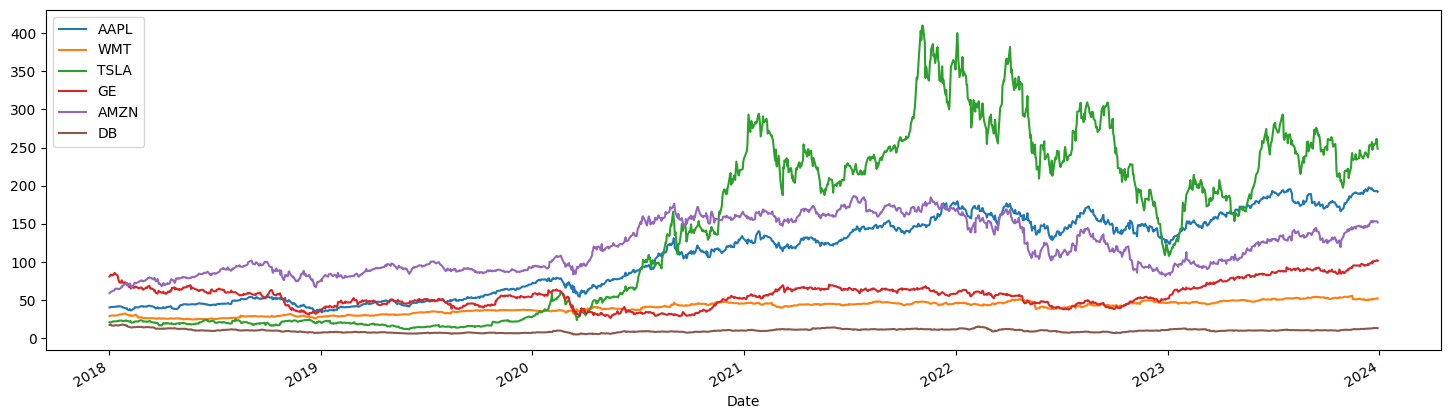

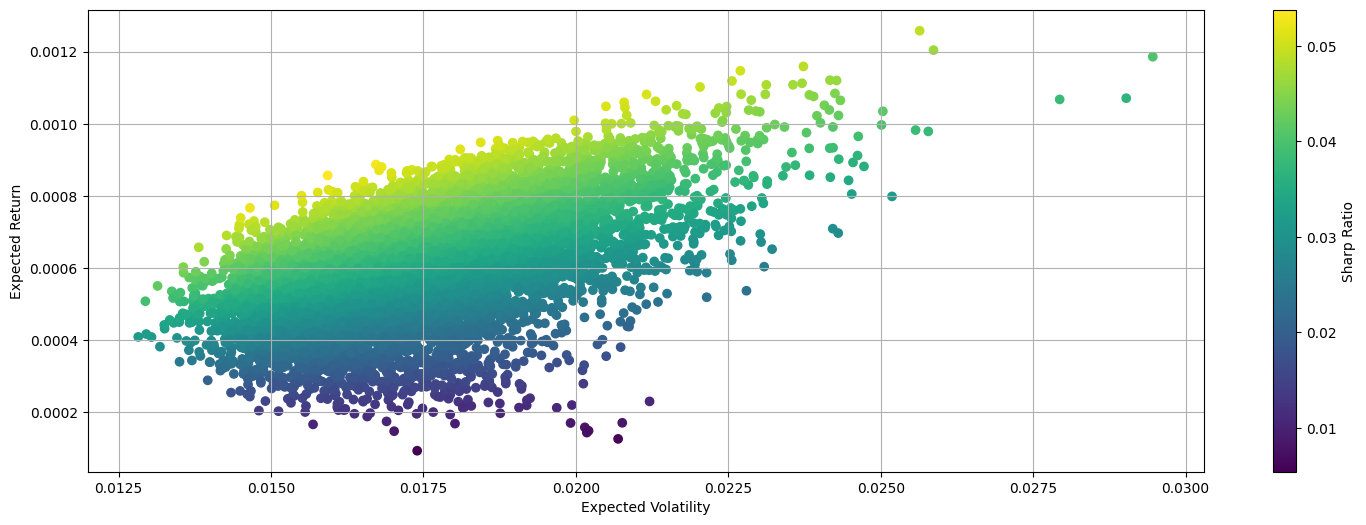

Optimal portfolio: [0.505 0.402 0.093 0.    0.    0.   ]
Expected return, volatility and sharp ratio: [0.00082508 0.01523494 0.05415677]


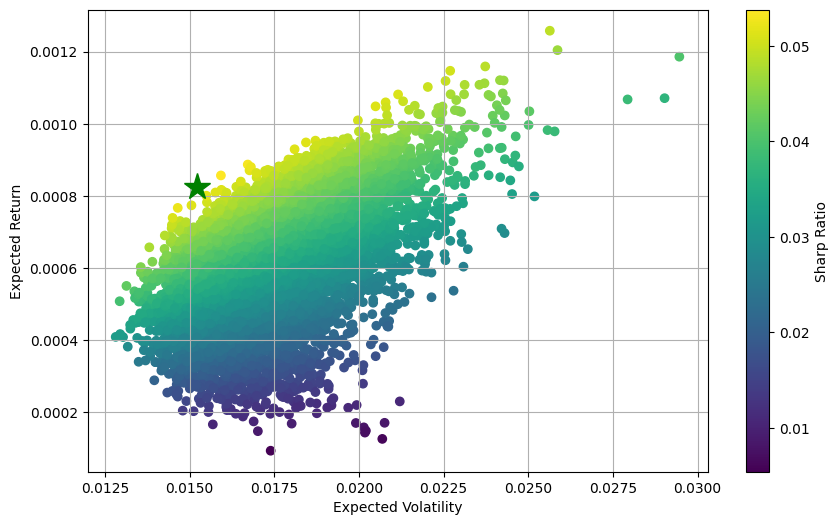

In [16]:
if __name__ == '__main__':
  dataset = (download_data())
  show_data(dataset)
  log_daily_returns = calculate_return(dataset)
  #show_statistics(log_daily_returns)

  pweights, means, risks = generate_portfolios(log_daily_returns)
  show_portfolios(means, risks)
  optimum = optimize_portfolio(pweights, log_daily_returns)
  print_optimal_portfolio(optimum, log_daily_returns)
  show_optimal_portfolios(optimum, log_daily_returns, means, risks)
